In [23]:
import numpy as np
import scipy.io
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

# load `.mat` file
data = scipy.io.loadmat('face.mat')

# Images
# N: number of images
# D: number of pixels
X = data['X']  # shape: [D x N]
y = data['l']  # shape: [1 x N]

assert(X.shape[1] == y.shape[1])
# Number of images
D, N = X.shape

# Fix the random seed
np.random.seed(13)

# Cardinality of labels
_card = len(set(y.ravel()))

# Step splitting of dataset
_step = int(N / _card)

# Shape boundaries
_bounds = np.arange(0, N+1, _step)

# Shapes
shapes = list(zip(_bounds[:-1], _bounds[1:]))

# Training Mask
_mask = []

for _shape in shapes:
    _idx = np.random.choice(
        np.arange(*_shape), int(0.8 * _step), replace=False)
    _mask.append(_idx)

mask_train = np.array(_mask).ravel()

mask_test = np.array(list(set(np.arange(0, N)) - set(mask_train)))

# Partition dataset to train and test sets
X_train, X_test = X[:, mask_train], X[:, mask_test]
y_train, y_test = y[:, mask_train], y[:, mask_test]

In [24]:
class PCA(object):
    """Principle Component Analysis."""

    def __init__(self, n_comps=5, standard=True):
        """Contructor.
        Parameters
        ----------
        n_comps: int
            Number of principle components
        """
        self._fitted = False
        self.n_comps = n_comps
        self.standard = standard
        self.mean = None
        self.U = None

    def fit(self, X):
        """Fit PCA according to `X.cov()`.
        Parameters
        ----------
        X: numpy.ndarray
            Features matrix
        Returns
        -------
        array: numpy.ndarray
            Transformed features matrix
        """
        self.D, N = X.shape
        self.mean = X.mean(axis=1).reshape(-1, 1)
        # center data
        A = X - self.mean
        # covariance matrix
        S = (1 / N) * np.dot(A.T, A)
        
        _l, _v = np.linalg.eig(S)

        _indexes = np.argsort(_l)[::-1]

        # Sorted eigenvalues and eigenvectors
        l, v = _l[_indexes], _v[:, _indexes]

        V = v[:, :self.n_comps]

        _U = np.dot(A, V)

        self.U = _U / np.apply_along_axis(np.linalg.norm, 0, _U)

        W = np.dot(self.U.T, A)

        if self.standard:
            self.W_mean = np.mean(W, axis=1)
            self.W_std = np.std(W, axis=1)

        self._fitted = True

        if self.standard:
            return ((W.T - self.W_mean) / self.W_std).T
        else:
            return W

    def transform(self, X):
        """Transform `X` by projecting it to PCA feature space.
        Parameters
        ----------
        X: numpy.ndarray
            Features matrix
        Returns
        -------
        array: numpy.ndarray
            Transformed features matrix
        """

        Phi = X - self.mean

        W = np.dot(self.U.T, Phi)

        if self.standard:
            return ((W.T - self.W_mean) / self.W_std).T
        else:
            return W

    def reconstruct(self, W):
        """Recontruct compressed data.
        Parameters
        ----------
        W: numpy.ndarray
            Projection coefficients matrix
        Returns
        -------
        X_hat: numpy.ndarray
            Reconstructed features matrix
        """
        A_hat = np.dot(self.U, W).reshape(-1, 1)
        A_hat = A_hat + self.mean
        return A_hat

In [25]:
# KNN Classifer
from sklearn.neighbors import KNeighborsClassifier

M = 1
standard = False
M_train = []
acc_train = []

D, N = X_train.shape

while M < 408:

    pca = PCA(n_comps=M, standard=standard)

    W_train = pca.fit(X_train)

    I, K = X_test.shape

    W_test = pca.transform(X_test)

    nn = KNeighborsClassifier(n_neighbors=1)
    nn.fit(W_train.T, y_train.T.ravel())
    acc = nn.score(W_test.T, y_test.T.ravel())
    print('Accuracy = %.2f%%' % (acc * 100))
    acc_train.append(acc*100)
    M_train.append(M)
    M = M + 1

Accuracy = 4.81%
Accuracy = 8.65%
Accuracy = 18.27%
Accuracy = 24.04%
Accuracy = 38.46%
Accuracy = 36.54%
Accuracy = 34.62%
Accuracy = 36.54%
Accuracy = 38.46%
Accuracy = 41.35%
Accuracy = 44.23%
Accuracy = 46.15%
Accuracy = 47.12%
Accuracy = 48.08%
Accuracy = 51.92%
Accuracy = 51.92%
Accuracy = 50.96%
Accuracy = 52.88%
Accuracy = 52.88%
Accuracy = 51.92%
Accuracy = 52.88%
Accuracy = 54.81%
Accuracy = 54.81%
Accuracy = 59.62%
Accuracy = 57.69%
Accuracy = 58.65%
Accuracy = 58.65%
Accuracy = 60.58%
Accuracy = 59.62%
Accuracy = 59.62%
Accuracy = 59.62%
Accuracy = 61.54%
Accuracy = 58.65%
Accuracy = 58.65%
Accuracy = 57.69%
Accuracy = 58.65%
Accuracy = 58.65%
Accuracy = 58.65%
Accuracy = 59.62%
Accuracy = 58.65%
Accuracy = 60.58%
Accuracy = 62.50%
Accuracy = 61.54%
Accuracy = 61.54%
Accuracy = 61.54%
Accuracy = 62.50%
Accuracy = 62.50%
Accuracy = 63.46%
Accuracy = 63.46%
Accuracy = 62.50%
Accuracy = 61.54%
Accuracy = 62.50%
Accuracy = 62.50%
Accuracy = 63.46%
Accuracy = 62.50%
Accuracy = 6

Text(0,0.5,'Recogniton Accuracy / %')

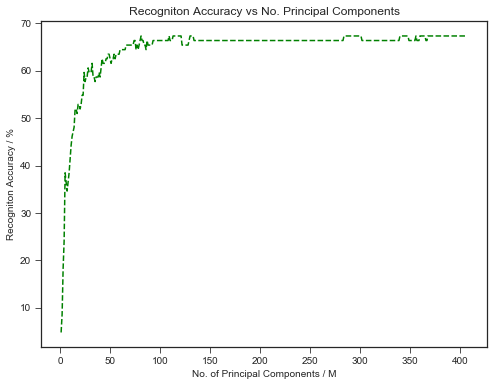

In [26]:
plt.figure(figsize=(8.0, 6.0))
plt.plot(M_train, acc_train, color='green', linestyle='dashed')
plt.title('Recogniton Accuracy vs No. Principal Components')
plt.xlabel('No. of Principal Components / M')
plt.ylabel('Recogniton Accuracy / %')

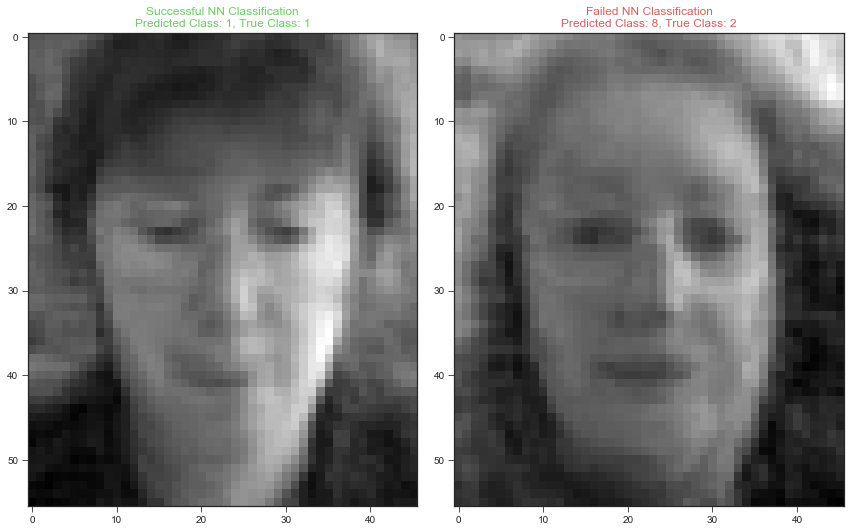

In [27]:
# prettify plots
plt.rcParams['figure.figsize'] = [12.0, 9.0]
sns.set_palette(sns.color_palette("muted"))
_palette = sns.color_palette("muted")
sns.set_style("ticks")


M = 121
standard = False

pca = PCA(n_comps=M, standard=standard)

W_train = pca.fit(X_train)

I, K = X_test.shape

W_test = pca.transform(X_test)

nn = KNeighborsClassifier(n_neighbors=1)
nn.fit(W_train.T, y_train.T.ravel())

y_hat = nn.predict(W_test.T)

done = {'success': False, 'failure': False}

fig, axes = plt.subplots(ncols=2)

for y, t, w in zip(y_hat, y_test.T.ravel(), W_test.T):
    if y == t and done['success'] is False:
        x_hat = pca.reconstruct(w)
        axes[0].imshow(x_hat.reshape(46,56).T,
                       cmap=plt.get_cmap('gray'))
        axes[0].set_title(
            'Successful NN Classification\nPredicted Class: %d, True Class: %d' % (y, t), color=_palette[1])
        done['success'] = True
    elif y != t and done['failure'] is False:
        x_hat = pca.reconstruct(w)
        axes[1].imshow(x_hat.reshape(46,56).T,
                       cmap=plt.get_cmap('gray'))
        axes[1].set_title(
            'Failed NN Classification\nPredicted Class: %d, True Class: %d' % (y, t), color=_palette[2])
        done['failure'] = True
    #elif done['failure'] is True and done['success'] is True:
     #break

fig.tight_layout()

In [21]:
# Alternative Method

from sklearn.metrics import accuracy_score

M = 121
standard = False

D, N = X_train.shape
_step = 8
_card = 5

PCA_insts = []
y_hat = []
rec_err = []

print (X_train.shape)

for i in range(52):
    pca = PCA(n_comps=M, standard=standard)
    
    W_train = pca.fit(X_train[:,_step*i:_step*i+7])
    
    #print ("getting from indexes ", _step*i , " to ", _step*i+7, "\n")
    
    PCA_insts.append(pca)
    
    W_test = pca.transform(X_test)
    
    print("enter loop \n ")
    print (X_test.T.shape)
    print (W_test.T.shape)
    
    for k, (x, w) in enumerate(zip(X_test.T, W_test.T)):
    
        #print("loop for ", k, "\n")
        x_hat = pca.reconstruct(w)
        
        _rec_err = np.linalg.norm(x_hat-x)
        
        if len(y_hat) <= k:
            print ("added element ", k)
            y_hat.append(int(i))
            rec_err.append(_rec_err)
        elif _rec_err < rec_err[k]:
            print ("_rec_err = ", _rec_err, " and rec_err[k] = ", rec_err[k])
            print ("k = ", k)
            y_hat[k] = int(i)
            rec_err[k] = _rec_err




(2576, 416)
enter loop 
 
(104, 2576)
(104, 7)
added element  0
added element  1
added element  2
added element  3
added element  4
added element  5
added element  6
added element  7
added element  8
added element  9
added element  10
added element  11
added element  12
added element  13
added element  14
added element  15
added element  16
added element  17
added element  18
added element  19
added element  20
added element  21
added element  22
added element  23
added element  24
added element  25
added element  26
added element  27
added element  28
added element  29
added element  30
added element  31
added element  32
added element  33
added element  34
added element  35
added element  36
added element  37
added element  38
added element  39
added element  40
added element  41
added element  42
added element  43
added element  44
added element  45
added element  46
added element  47
added element  48
added element  49
added element  50
added element  51
added element  52
added ele

_rec_err =  116081.96862851348  and rec_err[k] =  119646.01259781615
k =  83
_rec_err =  131571.90502468462  and rec_err[k] =  131993.0841382455
k =  84
_rec_err =  188555.23789756812  and rec_err[k] =  190816.3569745725
k =  91
_rec_err =  163526.05299205746  and rec_err[k] =  164048.96201830657
k =  92
_rec_err =  148581.88258717908  and rec_err[k] =  150109.90887478983
k =  93
_rec_err =  135159.38816282264  and rec_err[k] =  136900.83196262448
k =  95
_rec_err =  135761.32785662852  and rec_err[k] =  136861.795426292
k =  97
_rec_err =  172844.37083313635  and rec_err[k] =  181263.51516752812
k =  101
enter loop 
 
(104, 2576)
(104, 7)
enter loop 
 
(104, 2576)
(104, 7)
enter loop 
 
(104, 2576)
(104, 7)
_rec_err =  156514.01601836286  and rec_err[k] =  164639.90611299672
k =  0
_rec_err =  144112.28394303072  and rec_err[k] =  152700.8069369949
k =  1
_rec_err =  149344.60746463036  and rec_err[k] =  158219.015512918
k =  2
_rec_err =  120207.35054643097  and rec_err[k] =  126394.

_rec_err =  171638.16174488812  and rec_err[k] =  173238.37187444358
k =  43
_rec_err =  170048.7097350284  and rec_err[k] =  172844.37083313635
k =  101
enter loop 
 
(104, 2576)
(104, 7)
enter loop 
 
(104, 2576)
(104, 7)
_rec_err =  159137.45621195887  and rec_err[k] =  161125.97618102172
k =  7
_rec_err =  128886.05241800865  and rec_err[k] =  130093.67198139241
k =  41
_rec_err =  129205.84087773753  and rec_err[k] =  130489.16968397218
k =  102
enter loop 
 
(104, 2576)
(104, 7)
enter loop 
 
(104, 2576)
(104, 7)
_rec_err =  161151.43159506342  and rec_err[k] =  162776.28760590707
k =  53
_rec_err =  157449.70275017695  and rec_err[k] =  161904.15841528788
k =  60
_rec_err =  146907.67993667736  and rec_err[k] =  146947.45081864134
k =  62
_rec_err =  155950.46676049326  and rec_err[k] =  157122.47485666652
k =  78
enter loop 
 
(104, 2576)
(104, 7)
_rec_err =  178336.4096028959  and rec_err[k] =  182182.20040913898
k =  64
enter loop 
 
(104, 2576)
(104, 7)
_rec_err =  116793.96

In [22]:
print ("y_hat len = ", len(y_hat))

print (y_hat)
print (y_test)
print ("y_test shape: ", y_test.T.shape)
acc = accuracy_score(y_test.T, y_hat)    
print('Accuracy = %.2f%%' % (acc * 100))
    
    
    
    
print (PCA_insts)
print (len(PCA_insts))

y_hat len =  104
[7, 7, 7, 15, 4, 8, 1, 25, 15, 15, 8, 4, 7, 7, 7, 7, 8, 15, 33, 33, 25, 7, 38, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 41, 15, 7, 9, 41, 11, 7, 9, 7, 7, 7, 7, 7, 15, 7, 38, 7, 13, 7, 7, 7, 7, 15, 7, 34, 7, 34, 7, 14, 7, 7, 7, 7, 7, 7, 7, 7, 32, 34, 1, 7, 15, 32, 7, 7, 7, 15, 7, 7, 15, 7, 7, 15, 38, 7, 45, 7, 7, 7, 7, 7, 38, 7, 15, 7, 9, 38, 17]
[[ 1  1 52 52  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10 11 11
  12 12 13 13 14 14 15 15 16 16 17 17 18 18 19 19 20 20 21 21 22 22 23 23
  24 24 25 25 26 26 27 27 28 28 29 29 30 30 31 31 32 32 33 33 34 34 35 35
  36 36 37 37 38 38 39 39 40 40 41 41 42 42 43 43 44 44 45 45 46 46 47 47
  48 48 49 49 50 50 51 51]]
y_test shape:  (104, 1)
Accuracy = 3.85%
[<__main__.PCA object at 0x000001769E7D6DA0>, <__main__.PCA object at 0x000001769F1AAA90>, <__main__.PCA object at 0x000001769EB497F0>, <__main__.PCA object at 0x000001769EC80F98>, <__main__.PCA object at 0x000001769EF740B8>, <__main__.PCA object at 0x000001769AE37550>, <